In [14]:
# imports
import pandas as pd
import numpy as np

### clusGap function python equivalent from scripts/clusGap.py
from clusGap import clusGap
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
def generate_hypercube_clusters(n, k, side_length, noise_sd = 1.0):
    '''
    Generates 'n' clusters with 'k' points each in an n-dimensional space.
    Cluster centers are at the positive corners eg: (1,0,0); (0,1,0); (0,0,1) of a hypercube
    '''
    
    ### Actual code of the defined function

    # 1. Generating an identity matrix of n dimensions
    n_dim_cluster_centers = side_length * np.identity(n)
    
    # 2. Generate points around each center
    all_points = [] # Start with an empty list
    for center_coords in n_dim_cluster_centers: # Loop directly through each row of identity matrix (i.e, each cluster center)
        points_for_ith_center = np.random.normal(loc=center_coords, scale=noise_sd, size=(k, n))
        all_points.append(points_for_ith_center) # Add the points to our list
        # We're appending all points to the empty list above. It's kinda implicit to do it without any separation like n-dimensional array because the whole point is to find separation in the clusters with the algorithms. So, we use np.vstack() next to combine all the points

    # 3. Combine points from all clusters into one array
    final_data = np.vstack(all_points) # Vertically stack the arrays
    return final_data # Return the final dataset

In [13]:
# Test
# Define the simulation parameters
# Lists to loop on...
dimensions_to_test = [6, 5, 4, 3, 2]
side_lengths_to_test = range(10, 0, -1) # Creates numbers from 10 down to 1
k = 100
noise_sd = 1.0

results = [] # To store the outcomes

# Outer loop for dimensions
for n in dimensions_to_test:
    print(f"Testing dimension n={n}...")
    # Inner loop for side lengths
    for side_length in side_lengths_to_test:
        # Inside this loop, we do the work for each specific combination
        # 1. Generate the data
        data = generate_hypercube_clusters(n, k, side_length, noise_sd)

        # 2. Estimate optimal K using Gap Statistic
        max_clusters_to_test = n + 5 # Set the maximum K to check

        # Define the K-means function to pass to clusGap
        # [cite_start]Use n_init=20 and max_iter=50 as specified [cite: 33, 34]
        kmeans_func = KMeans(n_init=20, max_iter=50, random_state=42)

        # Run clusGap - use B=10 for speed during testing, d_power=1 for R compatibility
        gap_result = clusGap(data, FUNcluster=kmeans_func, K_max=max_clusters_to_test, B=10, d_power=1)

        estimated_k = gap_result['optimal_k'] # Extract the optimal k found

        
        # 3. Store the results for this iteration
        results.append({
            'n': n,
            'side_length': side_length,
            'estimated_k': estimated_k
        })

print("Simulation complete!")

Testing dimension n=6...
Testing dimension n=5...
Testing dimension n=4...
Testing dimension n=3...
Testing dimension n=2...
Simulation complete!


In [15]:
# Convert the results list into a pandas df
results_df = pd.DataFrame(results)
print(results_df.head())

   n  side_length  estimated_k
0  6           10            6
1  6            9            6
2  6            8            6
3  6            7            6
4  6            6            6


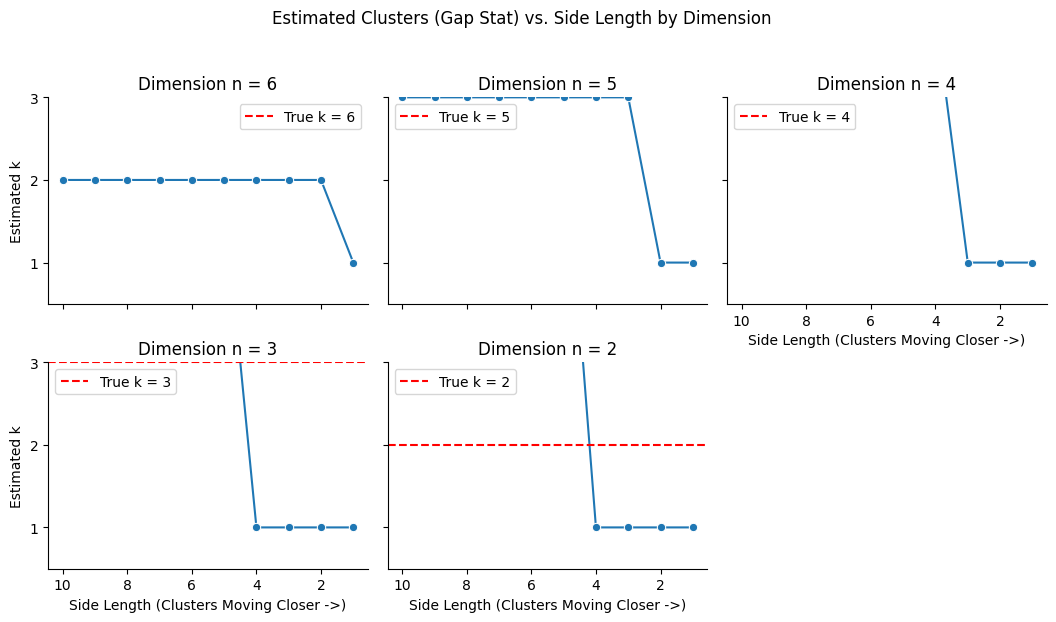

In [22]:
# Use seaborn's relplot to create faceted line plots
g = sns.relplot(
    data=results_df,
    x="side_length",
    y="estimated_k",
    col="n",            # Create separate columns for each dimension 'n'
    kind="line",        # Plot as lines
    marker="o",         # Add markers for each point
    col_wrap=3,         # Wrap facets into 3 columns
    height=3,           # Adjust plot height
    aspect=1.2          # Adjust aspect ratio
)

# Add the reference line (true number of clusters) to each facet
# The true number of clusters 'n' is the same as the column title
for ax, n_val in zip(g.axes.flat, sorted(results_df['n'].unique(), reverse=True)):
    ax.axhline(y=n_val, color='red', linestyle='--', label=f'True k = {n_val}')
    ax.legend()
    ax.set_title(f"Dimension n = {n_val}") # Set titles explicitly
    # Ensure y-axis starts near 1 and includes max estimated k + 1
    max_k_in_facet = results_df[results_df['n'] == n_val]['estimated_k'].max()
    ax.set_ylim(0.5, max(n_val, max_k_in_facet) + 1)
    ax.invert_xaxis() # Put side_length 10 on the left, 1 on the right

# Add overall title and adjust layout
g.fig.suptitle("Estimated Clusters (Gap Stat) vs. Side Length by Dimension", y=1.03)
g.set_axis_labels("Side Length (Clusters Moving Closer ->)", "Estimated k")
g.tight_layout()

# Set integer ticks for the y-axis on all subplots
for ax in g.axes.flat:
    # Find the maximum estimated k shown on this subplot
    max_k_on_axis = int(ax.get_ylim()[1]) # Get upper y-limit and convert to integer
    # Create a list of integer ticks from 1 up to the max k
    integer_ticks = range(1, max_k_on_axis + 1)
    ax.set_yticks(integer_ticks) # Apply these integer ticks to the y-axis

# Save the plot
plt.savefig("../figures/gap_statistic_simulation.png")
plt.show() # Display the plot in the notebook

## Task 1 Interpretation

Based on the plot, the Gap Statistic's performance is mixed and highly dependent on the data's dimensionality.

* **Failure in High Dimensions (n=6, n=5):** The algorithm **fails** to identify the correct number of clusters, even when the clusters are far apart (side length 10).
    * For `n=6`, it incorrectly estimates `k=2` (when the truth is 6).
    * For `n=5`, it incorrectly estimates `k=3` (when the truth is 5).
    This suggests that in 5 or more dimensions, the clusters are already too complex or overlapping for this method to distinguish.

* **Success then Failure in Low-Mid Dimensions (n=4, n=3):** The algorithm **succeeds at first, then fails** as dimensions decrease.
    * For `n=4`, it correctly estimates the true `k=4` until the `side_length` drops to **3**, at which point it fails and drops to `k=1`.
    * For `n=3`, it correctly estimates the true `k=3` until the `side_length` drops to **4**, at which point it fails and drops to `k=1`.

* **Anomalous Result (n=2):** The pattern for `n=2` is different from the others. The algorithm **fails** at large side lengths (estimating `k=1` from 10 down to 5). It then briefly **succeeds** at `side_length=4` (correctly estimating `k=2`), before **failing again** (dropping to `k=1`) for all smaller side lengths.

This shows the method is unstable. It fails in high dimensions, and while it succeeds in low-mid dimensions, it breaks down as soon as the clusters get too close (around a `side_length` of 3 or 4). The `n=2` result is an anomaly, suggesting the Gap Statistic calculation might be highly variable and unreliable under certain conditions.

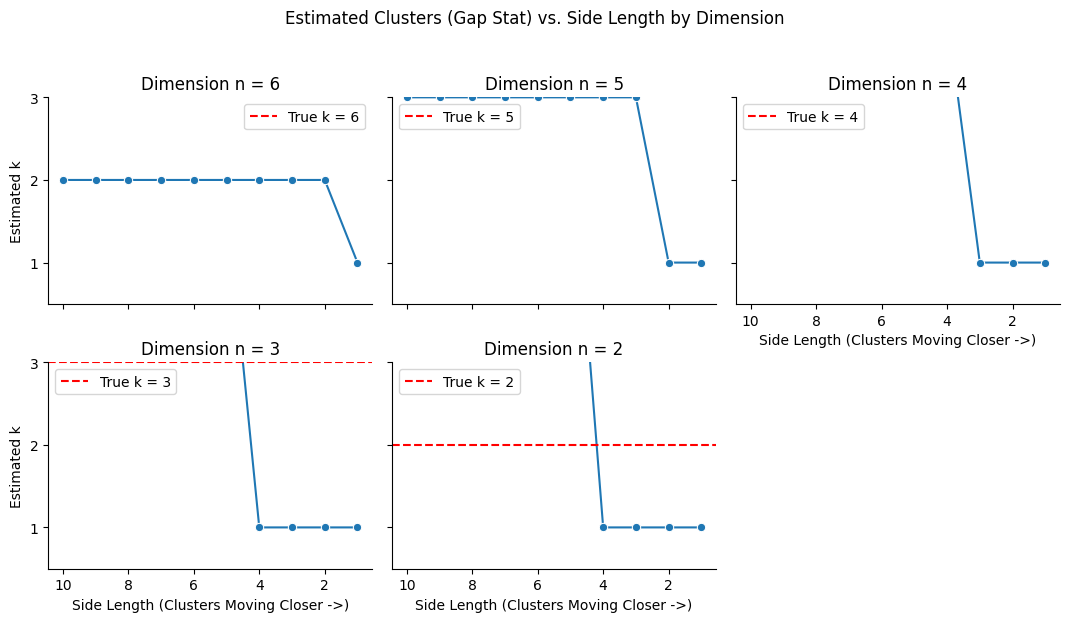

In [21]:
'''# Use seaborn's relplot to create faceted line plots
g = sns.relplot(
    data=results_df,
    x="side_length",
    y="estimated_k",
    col="n",
    kind="line",
    marker="o",
    col_wrap=3,
    height=3,
    aspect=1.2
)

# Customize each subplot (facet)
for ax, n_val in zip(g.axes.flat, sorted(results_df['n'].unique(), reverse=True)):
    # Add the reference line (true number of clusters)
    ax.axhline(y=n_val, color='red', linestyle='--', label=f'True k = {n_val}')
    ax.legend()
    ax.set_title(f"Dimension n = {n_val}")

    # --- New Y-axis limits and Ticks Logic ---
    # Find the minimum and maximum estimated k values *actually plotted* in this facet
    estimates_in_facet = results_df[results_df['n'] == n_val]['estimated_k']
    min_k_observed = estimates_in_facet.min() if not estimates_in_facet.empty else 1
    max_k_observed = estimates_in_facet.max() if not estimates_in_facet.empty else n_val

    # Determine the y-axis range needed to show everything
    # Ensure the range includes 1, the true k (n_val), and the max observed k
    y_min = 0.5 # Start slightly below 1
    y_max = max(n_val, max_k_observed) + 0.5 # Go slightly above the highest value needed

    # Generate integer ticks from 1 up to the ceiling of y_max
    # Use np.ceil to round up, ensuring the highest integer is included
    integer_ticks = np.arange(1, int(np.ceil(y_max)) + 1)

    ax.set_ylim(y_min, y_max) # Set y-axis limits
    ax.set_yticks(integer_ticks) # Set only integer ticks
    # --- End New Logic ---

    # Flip the x-axis
    ax.invert_xaxis()

# Add overall title and adjust layout
g.fig.suptitle("Estimated Clusters (Gap Stat) vs. Side Length by Dimension", y=1.03)
g.set_axis_labels("Side Length (Clusters Moving Closer ->)", "Estimated k")
g.tight_layout()

# Save the plot (using corrected relative path)
plt.savefig("../figures/gap_statistic_simulation.png")

# Display the plot in the notebook output
plt.show()'''